In [267]:
#pip install imblearn

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Load the data

In [269]:
df_users = pd.read_csv('./data/takehome_users.csv',encoding='latin1')
print(df_users.shape)
df_users.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [270]:
df_users_eng = pd.read_csv('./data/takehome_user_engagement.csv',encoding='latin1')
print(df_users_eng.shape)
df_users_eng.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Data wrangling

In [271]:
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'],unit='s')

In [272]:
df_users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [273]:
df_users_eng['time_stamp'] = pd.to_datetime(df_users_eng['time_stamp'])

In [274]:
df_users_eng.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [275]:
df_users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [276]:
df_users_eng.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [277]:
# fill null value of last_session_creation_time in df_users with data from df_users_eng
last_session_df = df_users_eng.groupby('user_id')['time_stamp'].max().reset_index()
last_session_df = last_session_df.rename(columns={'time_stamp': 'last_session_creation_time'})
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].fillna(last_session_df['last_session_creation_time'])

# If there is no invitation from other user, we fill it with 0
df_users['invited_by_user_id'] = df_users['invited_by_user_id'].fillna(0)

df_users.isna().sum()	

object_id                       0
creation_time                   0
name                            0
email                           0
creation_source                 0
last_session_creation_time    811
opted_in_to_mailing_list        0
enabled_for_marketing_drip      0
org_id                          0
invited_by_user_id              0
dtype: int64

we are going to fill the rest of the missing values in last_session_creation_time with their corresponding creation_time 

In [278]:
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].fillna(df_users['creation_time'])
df_users.isna().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

# Create the target variable: user adoption

In [279]:
login_days = df_users_eng.groupby('user_id')['time_stamp'].nunique()

active_users = login_days[login_days >= 3].index
active_users

Index([    2,    10,    20,    33,    42,    43,    50,    53,    59,    60,
       ...
       11961, 11964, 11965, 11967, 11969, 11975, 11980, 11981, 11988, 11991],
      dtype='int64', name='user_id', length=2248)

In [280]:
def has_three_logins_in_seven_days(user_logins):
    user_logins = sorted(user_logins)
    for i in range(len(user_logins) - 2):
        for j in range(i + 2, len(user_logins)):
            if (user_logins[j] - user_logins[i]).days <= 7:
                return True
    return False

adopted_users = []
for user_id in active_users:
    user_logins = df_users_eng[df_users_eng['user_id'] == user_id]['time_stamp'].unique()
    if has_three_logins_in_seven_days(user_logins):
        adopted_users.append(user_id)

df_users['adopted'] = df_users['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

In [281]:
df_users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


# Feature engineering

We propose adding the total number of logins as a new features.

In [282]:
total_logins = df_users_eng.groupby('user_id')['time_stamp'].count().reset_index()
total_logins = total_logins.rename(columns={'time_stamp': 'total_logins'})
df_users = pd.merge(df_users, total_logins, left_on='object_id', right_on='user_id', how='left')
df_users.drop(columns=['user_id'],inplace=True)
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,total_logins
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1.0


In [283]:
df_users['total_logins'] = df_users['total_logins'].fillna(0)

In [284]:
df_users_eng = df_users_eng.sort_values(by=['user_id', 'time_stamp'])

df_users_eng['days_between_logins'] = df_users_eng.groupby('user_id')['time_stamp'].diff().dt.days
df_users_eng['days_between_logins'] = df_users_eng['days_between_logins'].fillna(0)

average_days_df = df_users_eng.groupby('user_id')['days_between_logins'].mean().reset_index()
average_days_df = average_days_df.rename(columns={'days_between_logins': 'avg_days_between_logins'})
df_users = pd.merge(df_users, average_days_df[['user_id', 'avg_days_between_logins']], 
                     left_on='object_id', right_on='user_id', how='left')

df_users.drop(columns=['user_id'],inplace=True)
df_users.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,total_logins,avg_days_between_logins
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1.0,0.000000
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,14.0,9.714286
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1.0,0.000000
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1.0,0.000000
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1.0,0.000000


In [285]:
# fill the NaN values
df_users['avg_days_between_logins'] = df_users['avg_days_between_logins'].fillna(-1)
df_users.isna().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted                       0
total_logins                  0
avg_days_between_logins       0
dtype: int64

In [286]:
df_users_eng['weekday'] = df_users_eng['time_stamp'].dt.weekday

df_users_eng['is_weekend'] = df_users_eng['weekday'].apply(lambda x: 1 if x >= 5 else 0)

login_counts = df_users_eng.groupby('user_id').agg(
    weekend_logins=('is_weekend', lambda x: (x == 1).sum())
).reset_index()

df_users = pd.merge(df_users, login_counts, 
                     left_on='object_id', right_on='user_id', how='left')

df_users.drop(columns=['user_id'],inplace=True)
df_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,total_logins,avg_days_between_logins,weekend_logins
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1.0,0.000000,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,14.0,9.714286,4.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1.0,0.000000,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1.0,0.000000,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0,1.0,0.000000,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,0.0,0,1.0,0.000000,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0,1.0,0.000000,1.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,0.0,0,1.0,0.000000,1.0


In [287]:
df_users['weekend_logins'] = df_users['weekend_logins'].fillna(0)

# EDA

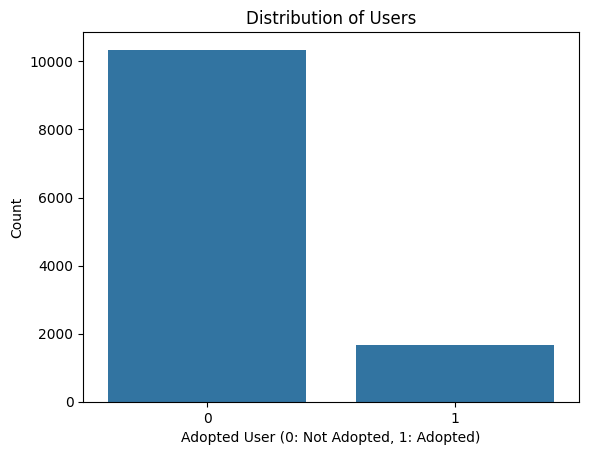

In [288]:
sns.countplot(x='adopted', data=df_users)
plt.title('Distribution of Users')
plt.xlabel('Adopted User (0: Not Adopted, 1: Adopted)')
plt.ylabel('Count')
plt.show()

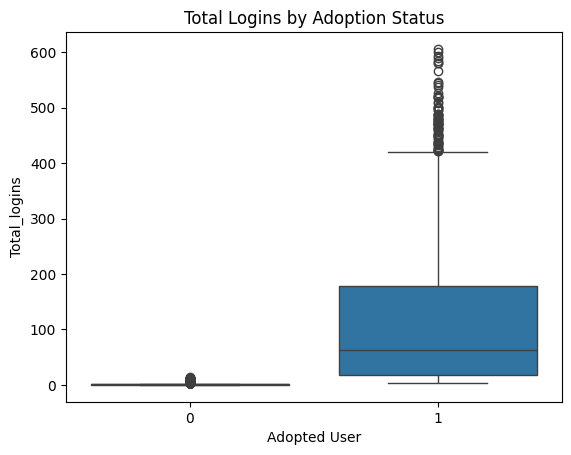

In [289]:
sns.boxplot(x='adopted', y='total_logins', data=df_users)
plt.title('Total Logins by Adoption Status')
plt.xlabel('Adopted User')
plt.ylabel('Total_logins')
plt.show()

Adopted users logged in more often than non-adopted users.

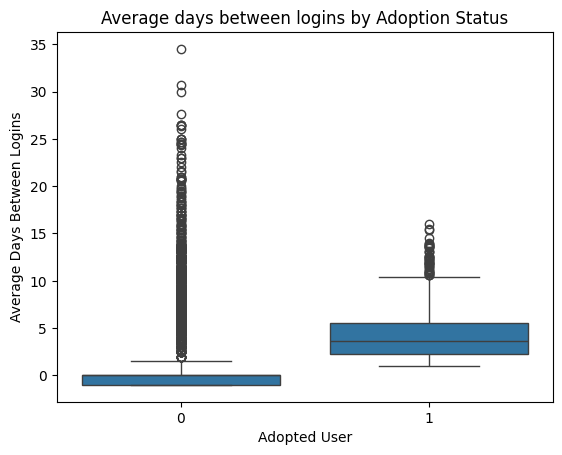

In [290]:
sns.boxplot(x='adopted', y='avg_days_between_logins', data=df_users)
plt.title('Average days between logins by Adoption Status')
plt.xlabel('Adopted User')
plt.ylabel('Average Days Between Logins')
plt.show()

Many of the non-adopted users logged in only once (negative as we filled the null values with -1), and a significant number of them had long intervals between logins.

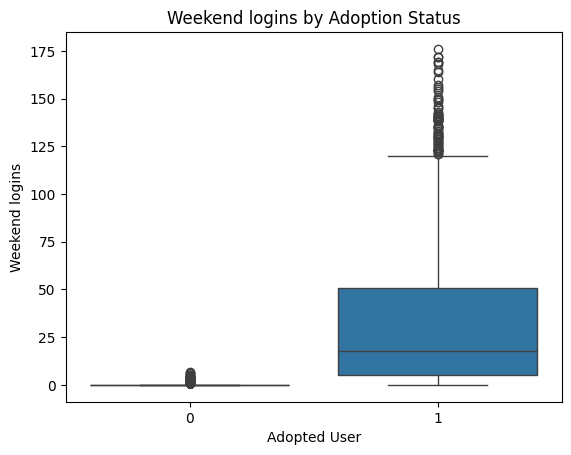

In [291]:
sns.boxplot(x='adopted', y='weekend_logins', data=df_users)
plt.title('Weekend logins by Adoption Status')
plt.xlabel('Adopted User')
plt.ylabel('Weekend logins')
plt.show()

Adopted users have more logins during weekends than non-adopted users.

In [292]:
corr=df_users[['opted_in_to_mailing_list','enabled_for_marketing_drip', 'total_logins','avg_days_between_logins','weekend_logins', 'org_id','adopted']].corr()
corr

,opted_in_to_mailing_list,enabled_for_marketing_drip,total_logins,avg_days_between_logins,weekend_logins,org_id,adopted
opted_in_to_mailing_list,1.000000,0.483529,0.005379,-0.007057,0.004251,0.003432,0.008838
enabled_for_marketing_drip,0.483529,1.000000,0.003932,0.004070,0.003064,0.009275,0.006578
total_logins,0.005379,0.003932,1.000000,0.121281,0.997769,0.048736,0.637572
avg_days_between_logins,-0.007057,0.004070,0.121281,1.000000,0.120544,0.053486,0.403850
weekend_logins,0.004251,0.003064,0.997769,0.120544,1.000000,0.049271,0.634625
org_id,0.003432,0.009275,0.048736,0.053486,0.049271,1.000000,0.066995
adopted,0.008838,0.006578,0.637572,0.403850,0.634625,0.066995,1.000000


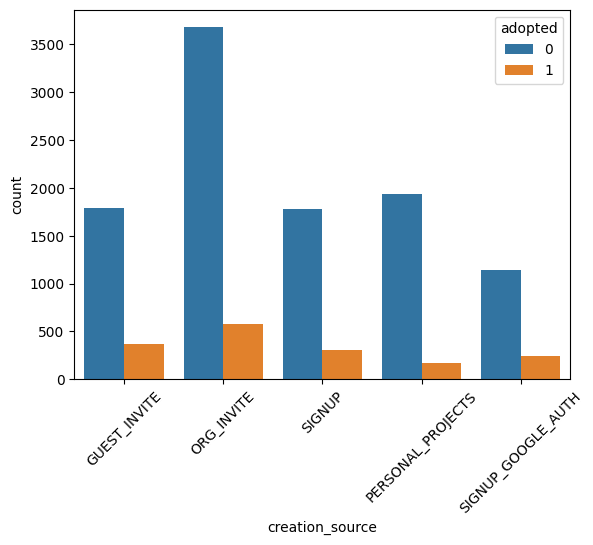

In [293]:
sns.countplot(x="creation_source",data=df_users,hue="adopted") 
plt.tick_params(axis='x', labelrotation=45)
plt.show()

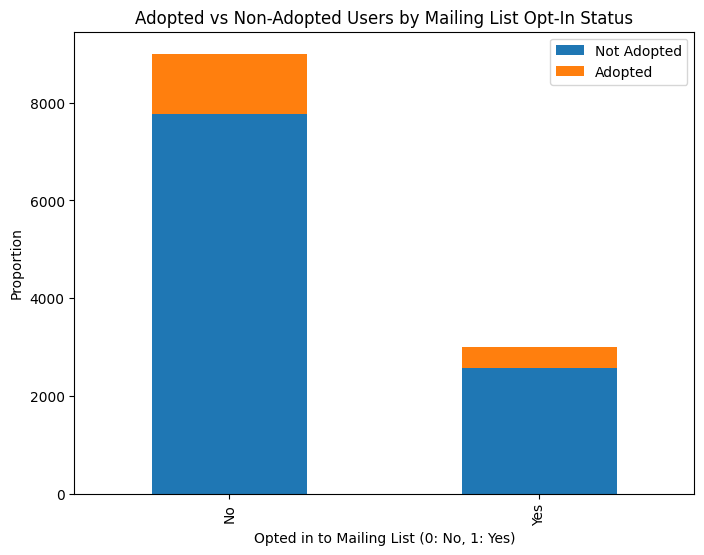

In [294]:
adopted_by_mailing_list = pd.crosstab(df_users['opted_in_to_mailing_list'], df_users['adopted'])  


adopted_by_mailing_list.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Adopted vs Non-Adopted Users by Mailing List Opt-In Status')
plt.xlabel('Opted in to Mailing List (0: No, 1: Yes)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No', 'Yes']) 
plt.legend(['Not Adopted', 'Adopted'], loc='upper right')
plt.show()

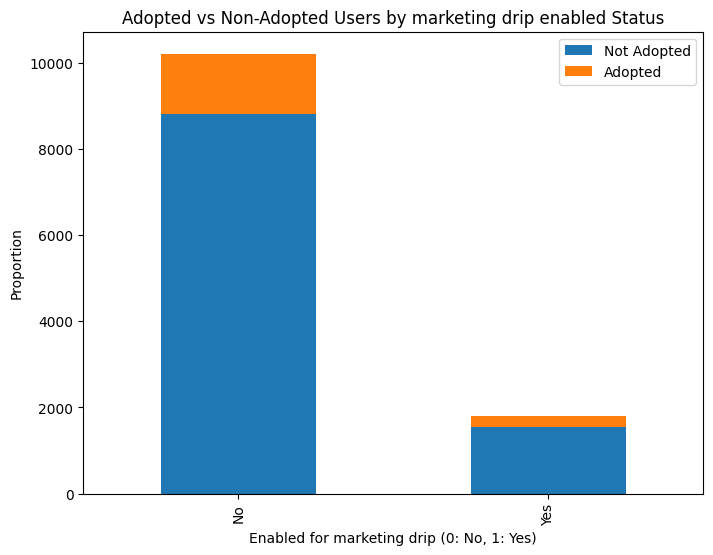

In [295]:
adopted_by_marketing = pd.crosstab(df_users['enabled_for_marketing_drip'], df_users['adopted'])  

adopted_by_marketing.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Adopted vs Non-Adopted Users by marketing drip enabled Status')
plt.xlabel('Enabled for marketing drip (0: No, 1: Yes)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No', 'Yes']) 
plt.legend(['Not Adopted', 'Adopted'], loc='upper right')
plt.show()

In [296]:
features = ['opted_in_to_mailing_list', 'creation_source','enabled_for_marketing_drip', 'total_logins','avg_days_between_logins','weekend_logins', 'org_id']  
target = 'adopted'

In [297]:
df = df_users[features]

In [298]:
df = pd.get_dummies(df, columns=['creation_source'], drop_first=True)

In [299]:
X = df
y = df_users[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, y_train)


RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

cv_scores = cross_val_score(RF_model, X_res, y_res, cv=5, scoring='accuracy')

print(f"Cross-validation scores for each fold: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

Cross-validation scores for each fold: [0.98272138 0.98488121 0.97186147 0.98484848 0.98051948]
Mean accuracy: 0.9810
Standard deviation of accuracy: 0.0048


In [300]:
RF_model.fit(X_train,y_train)
importances = RF_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances)

total_logins                          0.458160
weekend_logins                        0.315354
avg_days_between_logins               0.187043
org_id                                0.024829
creation_source_ORG_INVITE            0.002832
opted_in_to_mailing_list              0.002744
creation_source_PERSONAL_PROJECTS     0.002449
enabled_for_marketing_drip            0.002217
creation_source_SIGNUP_GOOGLE_AUTH    0.002200
creation_source_SIGNUP                0.002173
dtype: float64
